In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0610/weights_KD_segformer_0610_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.9
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 7s 811ms/step - loss: 0.0091
Average validation loss: 0.626323401927948
4/4 [==============================] - 7s 824ms/step - loss: 0.0091 - val_loss: 0.6263
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 10s 762ms/step - loss: 0.0066 - val_loss: 0.6263
Average validation loss: 0.5683135986328125
4/4 [==============================] - 10s 774ms/step - loss: 0.0066 - val_loss: 0.5973
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 13s 732ms/step - loss: 0.0050 - val_loss: 0.5973
Average validation loss: 0.4693504869937897
4/4 [==============================] - 13s 745ms/step - loss: 0.0050 - val_los

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 711ms/step - loss: 6.5844e-06
Average validation loss: 0.0011420552036724985
8/8 [==============================] - 6s 721ms/step - loss: 6.5844e-06 - val_loss: 0.0011
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 11s 700ms/step - loss: 6.5521e-06 - val_loss: 0.0011
Average validation loss: 0.00038624029548373073
8/8 [==============================] - 12s 710ms/step - loss: 6.5521e-06 - val_loss: 7.6415e-04
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 17s 679ms/step - loss: 6.5112e-06 - val_loss: 7.6415e-04
Average validation loss: 9.067927749129012e-05
8/8 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 8s 688ms/step - loss: 1.5971e-05
Average validation loss: 0.05836295916143778
12/12 [==============================] - 8s 699ms/step - loss: 1.5971e-05 - val_loss: 0.0584
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 17s 689ms/step - loss: 1.4713e-05 - val_loss: 0.0584
Average validation loss: 0.08344771226726759
12/12 [==============================] - 17s 700ms/step - loss: 1.4713e-05 - val_loss: 0.0709
Epoch 3/10
12/12 [==============================] - 25s 691ms/step - loss: 1.3867e-05 - val_loss: 0.0709
Average validation loss: 0.029954861345080037
12/12 [==============================] - 25s 701ms/step - loss: 1.3867e-05 - val_loss: 0.0573
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weigh

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 11s 699ms/step - loss: 9.0090e-06
Average validation loss: 0.0649701128313609
16/16 [==============================] - 11s 712ms/step - loss: 9.0090e-06 - val_loss: 0.0650
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 22s 694ms/step - loss: 8.8493e-06 - val_loss: 0.0650
Average validation loss: 0.03823727594863158
16/16 [==============================] - 23s 705ms/step - loss: 8.8493e-06 - val_loss: 0.0516
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 34s 701ms/step - loss: 8.6898e-06 - val_loss: 0.0516
Average validation loss: 0.022699664463289082
16/16 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 15s 722ms/step - loss: 5.2840e-06
Average validation loss: 0.05286753922700882
20/20 [==============================] - 15s 732ms/step - loss: 5.2840e-06 - val_loss: 0.0529
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 723ms/step - loss: 4.9241e-06 - val_loss: 0.0529
Average validation loss: 0.04503735546022654
20/20 [==============================] - 30s 734ms/step - loss: 4.9241e-06 - val_loss: 0.0490
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 47s 870ms/step - loss: 4.6208e-06 - val_loss: 0.0490
Average validation loss: 0.061132149398326875
20/20 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 21s 865ms/step - loss: 7.3128e-06
Average validation loss: 0.035332701789836087
24/24 [==============================] - 21s 880ms/step - loss: 7.3128e-06 - val_loss: 0.0353
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 42s 853ms/step - loss: 6.7036e-06 - val_loss: 0.0353
Average validation loss: 0.042346044753988586
24/24 [==============================] - 42s 867ms/step - loss: 6.7036e-06 - val_loss: 0.0388
Epoch 3/10
24/24 [==============================] - 63s 868ms/step - loss: 5.8599e-06 - val_loss: 0.0388
Average validation loss: 0.035092166935404144
24/24 [==============================] - 63s 883ms/step - loss: 5.8599e-06 - val_loss: 0.0376
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/w

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 35s 873ms/step - loss: 1.2398e-05
Average validation loss: 0.04731746129691601
40/40 [==============================] - 35s 887ms/step - loss: 1.2398e-05 - val_loss: 0.0473
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 70s 871ms/step - loss: 1.0420e-05 - val_loss: 0.0473
Average validation loss: 0.09000034667551518
40/40 [==============================] - 71s 884ms/step - loss: 1.0420e-05 - val_loss: 0.0687
Epoch 3/10
40/40 [==============================] - 106s 884ms/step - loss: 9.4753e-06 - val_loss: 0.0687
Average validation loss: 0.04322568941861391
40/40 [==============================] - 107s 897ms/step - loss: 9.4753e-06 - val_loss: 0.0602
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/we

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 34s 714ms/step - loss: 6.6400e-06
Average validation loss: 0.07130998225572209
48/48 [==============================] - 35s 725ms/step - loss: 6.6400e-06 - val_loss: 0.0713
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 69s 715ms/step - loss: 5.3601e-06 - val_loss: 0.0713
Average validation loss: 0.023181520654664684
48/48 [==============================] - 70s 724ms/step - loss: 5.3601e-06 - val_loss: 0.0472
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 104s 705ms/step - loss: 4.2909e-06 - val_loss: 0.0472
Average validation loss: 0.02237669809255749
48/48 [==============================]

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 40s 707ms/step - loss: 9.4067e-06
Average validation loss: 0.04053436136538429
56/56 [==============================] - 40s 718ms/step - loss: 9.4067e-06 - val_loss: 0.0405
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 80s 705ms/step - loss: 6.8491e-06 - val_loss: 0.0405
Average validation loss: 0.03129737425063338
56/56 [==============================] - 80s 715ms/step - loss: 6.8491e-06 - val_loss: 0.0359
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 119s 685ms/step - loss: 5.6754e-06 - val_loss: 0.0359
Average validation loss: 0.03045508568175137
56/56 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 44s 695ms/step - loss: 5.4232e-06
Average validation loss: 0.05240371869876981
64/64 [==============================] - 45s 706ms/step - loss: 5.4232e-06 - val_loss: 0.0524
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 90s 701ms/step - loss: 3.7740e-06 - val_loss: 0.0524
Average validation loss: 0.021022193250246346
64/64 [==============================] - 91s 711ms/step - loss: 3.7740e-06 - val_loss: 0.0367
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 136s 704ms/step - loss: 2.9247e-06 - val_loss: 0.0367
Average validation loss: 0.027501016214955598
64/64 [==============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 51s 704ms/step - loss: 5.0244e-06
Average validation loss: 0.02453108100841443
72/72 [==============================] - 51s 714ms/step - loss: 5.0244e-06 - val_loss: 0.0245
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 103s 711ms/step - loss: 3.5465e-06 - val_loss: 0.0245
Average validation loss: 0.018184466934245493
72/72 [==============================] - 103s 721ms/step - loss: 3.5465e-06 - val_loss: 0.0214
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 154s 703ms/step - loss: 2.7197e-06 - val_loss: 0.0214
Average validation loss: 0.017831550833458703
72/72 [============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 56s 704ms/step - loss: 5.0207e-06
Average validation loss: 0.02148174527101219
80/80 [==============================] - 57s 714ms/step - loss: 5.0207e-06 - val_loss: 0.0215
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 114s 714ms/step - loss: 3.4952e-06 - val_loss: 0.0215
Average validation loss: 0.018352081906050442
80/80 [==============================] - 115s 724ms/step - loss: 3.4952e-06 - val_loss: 0.0199
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 172s 705ms/step - loss: 2.7586e-06 - val_loss: 0.0199
Average validation loss: 0.014803507528267802
80/80 [==========================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 67s 699ms/step - loss: 7.9153e-06
Average validation loss: 0.04524469841271639
96/96 [==============================] - 68s 709ms/step - loss: 7.9153e-06 - val_loss: 0.0452
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 136s 703ms/step - loss: 5.4668e-06 - val_loss: 0.0452
Average validation loss: 0.029454064594271284
96/96 [==============================] - 137s 712ms/step - loss: 5.4668e-06 - val_loss: 0.0373
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 204s 702ms/step - loss: 4.2803e-06 - val_loss: 0.0373
Average validation loss: 0.03356020319430778
96/96 [===========================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 84s 698ms/step - loss: 4.9986e-06
Average validation loss: 0.020299027611811956
120/120 [==============================] - 85s 708ms/step - loss: 4.9986e-06 - val_loss: 0.0203
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 169s 703ms/step - loss: 3.4818e-06 - val_loss: 0.0203
Average validation loss: 0.017904800230947635
120/120 [==============================] - 170s 713ms/step - loss: 3.4818e-06 - val_loss: 0.0191
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 254s 695ms/step - loss: 2.7835e-06 - val_loss: 0.0191
Average validation loss: 0.016489142598584295
120/120 [=============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 103s 713ms/step - loss: 2.7202e-06
Average validation loss: 0.02204936256425248
144/144 [==============================] - 104s 723ms/step - loss: 2.7202e-06 - val_loss: 0.0220
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 207s 715ms/step - loss: 2.0958e-06 - val_loss: 0.0220
Average validation loss: 0.0312896533606464
144/144 [==============================] - 209s 725ms/step - loss: 2.0958e-06 - val_loss: 0.0267
Epoch 3/10
144/144 [==============================] - 311s 711ms/step - loss: 1.7933e-06 - val_loss: 0.0267
Average validation loss: 0.02148815278067357
144/144 [==============================] - 312s 721ms/step - loss: 1.7933e-06 - val_loss: 0.0249
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_s

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 114s 714ms/step - loss: 1.4650e-06
Average validation loss: 0.02856218107172026
160/160 [==============================] - 116s 724ms/step - loss: 1.4650e-06 - val_loss: 0.0286
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 230s 715ms/step - loss: 1.1149e-06 - val_loss: 0.0286
Average validation loss: 0.01936801774500054
160/160 [==============================] - 232s 726ms/step - loss: 1.1149e-06 - val_loss: 0.0240
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 346s 710ms/step - loss: 9.0891e-07 - val_loss: 0.0240
Average validation loss: 0.017096797824501665
160/160 [=============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 142s 711ms/step - loss: 7.4571e-06
Average validation loss: 0.0162128648837097
200/200 [==============================] - 144s 722ms/step - loss: 7.4571e-06 - val_loss: 0.0162
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 287s 715ms/step - loss: 4.8944e-06 - val_loss: 0.0162
Average validation loss: 0.02625417850329541
200/200 [==============================] - 289s 725ms/step - loss: 4.8944e-06 - val_loss: 0.0212
Epoch 3/10
200/200 [==============================] - 433s 715ms/step - loss: 3.8506e-06 - val_loss: 0.0212
Average validation loss: 0.013191708463127725
200/200 [==============================] - 435s 726ms/step - loss: 3.8506e-06 - val_loss: 0.0186
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:44 - loss: 7.8259e-07

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 167s 694ms/step - loss: 3.1974e-06
Average validation loss: 0.02440449930339431
240/240 [==============================] - 169s 704ms/step - loss: 3.1974e-06 - val_loss: 0.0244
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_90\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 336s 695ms/step - loss: 2.1919e-06 - val_loss: 0.0244
Average validation loss: 0.02458676240761027
240/240 [==============================] - 338s 705ms/step - loss: 2.1919e-06 - val_loss: 0.0245
Epoch 3/10
240/240 [==============================] - 505s 697ms/step - loss: 1.7287e-06 - val_loss: 0.0245
Average validation loss: 0.02540665871153275
240/240 [==============================] - 508s 706ms/step - loss: 1.7287e-06 - val_loss: 0.0248
Epoch 4/10
240/240 [==============================] - 675s 695ms/step - loss: 1.5652e-06 - val_loss: 0.

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.10035646525939228, 0.05796608859136738, 0.08630540250582548, 0.054035788678811515, 0.046623885873239485, 0.02426629559505576, 0.03388175788556692, 0.02656364179061105, 0.025077053199721765, 0.0233577445265837, 0.01825052983435954, 0.018203801897856465, 0.022144769031486548, 0.019775502525968477, 0.020844230549450407, 0.02067771436680732, 0.02068512852795539, 0.02425024939944342]
std_val_losses =  [0.14816082323999896, 0.059522143470412237, 0.06596009515988648, 0.02530070000704057, 0.03998892961571826, 0.010951590806569135, 0.016901094856616814, 0.015501747222583448, 0.012107127320528715, 0.014347604249934372, 0.00954254960747442, 0.005596690741196849, 0.011864795955720325, 0.013361954204486859, 0.013222649091719484, 0.01123976105453721, 0.006249151781270299, 0.01824502021935617]


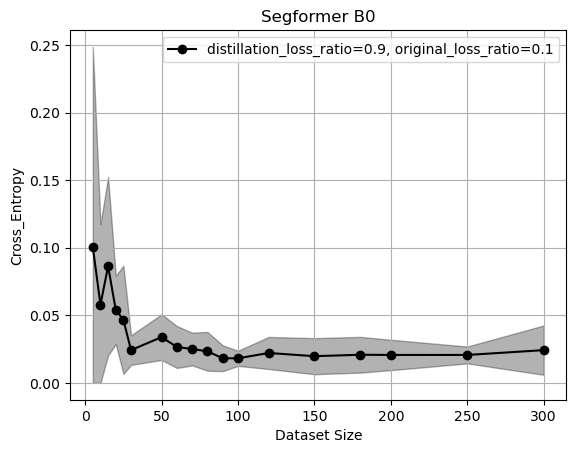

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0610')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.png"))

plt.show()